<h1>Problema 2: Resistencia de cultivos de bacterias</h1>
<p>Autor: Erick García Ramírez<br /> 
erick_phy@ciencias.unam.mx<br /> 
Curso de Aprendizaje Automatizado, MCIC 2019-2</p>

Buscamos entender cual es la influencia de los dos químicos en la supervivencia de las bacterias. Particularmente buscamos ser capaces de predecir cuál de las bacterias sobrevivirá dada ciertas concentraciones de los químicos. Veremos en el transcurso del problema que esto no es posible.

En este problema implementaremos un clasificador <em>directamente</em>, por lo que no cargamos la librería scikit-learn. 

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

En la siguiente celda cargamos los datos en <em>bacterias.csv</em>, y posteriormente los partimos directamente en tres columnas: X1 los valores de la concentración del primer químico, X2 los valores de la concentración del segundo químico, y B la lista de con la información de cuál bacteria sobrevivió. En términos de un problema de clasificación, B es el conjunto de etiquetas que busamos predecir. 

In [62]:
data = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea2/nb_data/bacterias.csv")
X1 = data.iloc[0:,0]
X2 = data.iloc[0:,1]
B = data.iloc[0:,2]

Para ver qué tipo de clasificador deberíamos construir, a continuación graficamos los histogramas del químico 1 (X1) y del químico 2 (X2). 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1ec719390>,
      dtype=object)

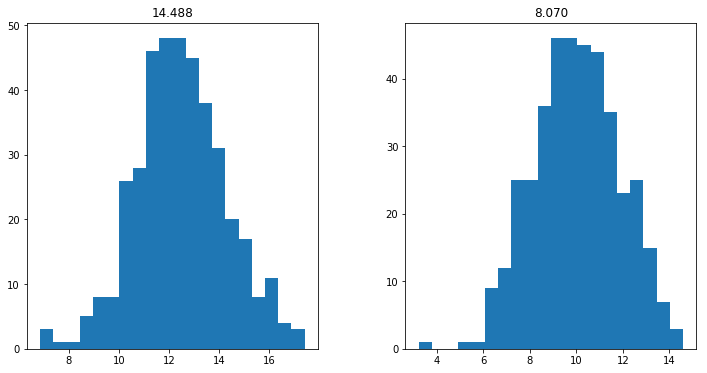

In [63]:
pd.DataFrame.hist(data.iloc[0:,:-1], grid=False,bins=20,figsize=(12,6))

<h1> Estimación de parámetros</h1>
Es muy claro a partir de los histogramas que es razonable suponer que X1 y X2 tienen una distribución normal. Por lo tanto, ahora comenzamos la tarea de construir el clasificador. Debemos aprender los parámetros $\hat \mu$ (la media) y $\hat \sigma^2$ (la varianza) para las distribuciones de X1 y X2. Nuestras decisiones finales seguiran el principio de máxima verosimilitud, i.e.

$$P(B= b|X_1 = x_1\wedge X_2=x_2)\propto P(B=b)P(X_1=x_1|B = b)P(X_2=x_2|B=b)$$


Comenzaremos por estimar los parámetros para las distribuciones normales $P(X_1=x_1|B = b)$ y $P(X_2=x_2|B=b)$. Como estamos siguiendo el principio de máxima verosimilitud, tenemos que  para $i=1,2$:
 $$\hat\mu_i=\text{media experimental para el quimico }i =\frac{1}{n}\sum_{k=1}^nX_i^{(k)}$$
 Y por otro lado,
 $$\hat \sigma_i^2=\text{varianza experimental para el quimico }i =\frac{1}{n}\sum_{k=1}^n(X_i^{(k)}-\hat\mu_i)^2$$

In [64]:
# Se supone que la distribución de cada químico es normal

# Estimación de la media de una columna
def mve_mu_estimation(col):
    s = 0
    for k in col.index:
        s += col.loc[k]
    return s/len(col)

# El parámetro mu estimado para X1
mu1 = mve_mu_estimation(X1)
# El parámetro mu estimado para X2
mu2 = mve_mu_estimation(X2)

# Estimación de la varianza de una columna
def mve_variance_estimation(col):
    mu = mve_mu_estimation(col)
    s = 0
    for k in col.index:
        s += (col.loc[k]-mu)**2
    return s/len(col)

# El parámetro sigma^2 para X1
var1 = mve_variance_estimation(X1)
# El parámetro sigma^2 para X2
var2 = mve_variance_estimation(X2)

# Imprimimos nuestras estimaciones
print('mu1=',mu1,'sigma1^2=',var1)
print('mu2=',mu2,'sigma2^2=',var2)

mu1= 10.00077192982456 sigma1^2= 3.3926943915930154
mu2= 12.478265664160398 sigma2^2= 3.218059222655635


Obtenemos que los parámetros para $P(X_1=x_1|B = b)$ son $\mu_1= 10.00077192982456$ y  $\sigma_1^2= 3.3926943915930154$. Para $P(X_2=x_2|B=b)$ son
$\mu_2= 12.478265664160398$ y $\sigma_2^2= 3.218059222655635$. 

Como sólo una de las bacterias puede sobrevivir (B sólo consta de dos valores, 0 y 1), es claro que podemos suponer que la distribución de $P(B=b)$ es bernoulli. Ahora aprendemos el parámetro $q$ para esta distrubución. Como pretendemos seguir el principio de máxima verosimilitud tenemos que 
$$\hat q = \frac{\text{ numero de experimentos en que sobrevivio la bacteria b }}{\text{ total de experimentos }}=\frac{N_b}{N}$$

Después de encontrar $\hat q$, imprimimos las probabilidades correspondientes de cada bacteria.

In [65]:
# Para la probabilidad de la clase suponemos una distribución Bernoulli. Calculamos el parámetro bajo el principio de máxima verosimilitud.
def qmve_of_class(cl):
    Nc=0
    for k in B.index:
        if B[k] == cl:
            Nc += 1
    return Nc/len(B)
print('Probabilidad de que la bacteria 1 sobreviva =', qmve_of_class(0))
print('Probabilidad de que la bacteria 2 sobreviva =', qmve_of_class(1))

Probabilidad de que la bacteria 1 sobreviva = 0.49874686716791977
Probabilidad de que la bacteria 2 sobreviva = 0.5012531328320802


<h1> Construcción del clasificador</h1> 
Ya estimamos los parámetros para las distribuciones $P(B=b)$, $P(X_1=x_1|B = b)$ y $P(X_2=x_2|B=b)$, así que ya tenemos todos los ingredientes para hacer predicciones. En la siguiente celda prob_of_surviving_bacteria es la función que regresa el producto 
 $$P(B=b)P(X_1=x_1|B = b)P(X_2=x_2|B=b)$$
 

In [66]:
# Calcular la probabilidad puntual (densidad) para una distribución normal
def normal_pd(x, mu, var):
    return (np.exp(-x-mu)**2/(2*var))/(2*np.pi*var)**.5

# Producto de P(B=b) P(X1=x1|B = b) con P(X2=x2|B=b). concentrations = [qty of X1,qty of X2]
def prob_of_surviving_bacteria(cl,concentrations):
    p = qmve_of_class(cl)
    p *= normal_pd(concentrations[0],mu1,var1)
    p *= normal_pd(concentrations[1],mu2,var2)
    return p    

La siguiente celda contiene la definición del clasificador, que simplemente decide que la bacteria que sobrevivirá es la que máximice a la estimación (salvo un factor normalizante) $P(B= b|X_1 = x_1\wedge X_2=x_2)$ dada por $P(B=b)P(X_1=x_1|B = b)P(X_2=x_2|B=b)$. 
    

In [67]:
# Construcción del modelo por máxima verosimilitud
def mve_classifierNB(concentrations):
    if prob_of_surviving_bacteria(0,concentrations) < prob_of_surviving_bacteria(1,concentrations):
        return 1
    if prob_of_surviving_bacteria(1,concentrations) < prob_of_surviving_bacteria(0,concentrations):
        return 0

print(X1.loc[0],X2.loc[0])
mve_classifierNB([8.684,12.804])

8.684 12.804


1

<h1> Rendimiento</h1>
Ahora analizamos el rendimiento del classificador construido. La función error_rate debajo regresa el número de errores cometidos por el clasificador. 

In [68]:
def errors():
    counter = 0
    for k in data.index:
        if mve_classifierNB([X1.loc[k],X2.loc[k]]) != B[k]:
            counter += 1
    return counter
e = errors()

In [69]:
print('Número de errores cometidos por mve_classifierNB:', e)
print('Porcentaje de aciertos:',  round(100*(len(B)-e)/len(B),2))

# Por clase, la tasa de error para la bacteria 0 es del 100%

Número de errores cometidos por mve_classifierNB: 199
Porcentaje de aciertos: 50.13


<h1>Conclusiones</h1>
Con un porcentaje de aciertos del 50% sabemos que mve_classifierNB no es mejor que lanzar una moneda para predecir cuál bacteria sobrevive. Sin embargo, lo que es aún más grave es que mve_classifierNB se equivoca en cada una de sus predicciones para la bacteria 2. La tasa de aciertos para la bacteria 1 es de 100% pero para la bacteria 2 es de 0%. Para el clasificador las bacterias son la misma. 

En este problema estamos ante un conjunto de datos para el cual nuestras técnicas de clasificación basadas en Naive Bayes fracasarán. Para ver la intuición de esto veamos como se esparcen las concentraciones de los químicos. 

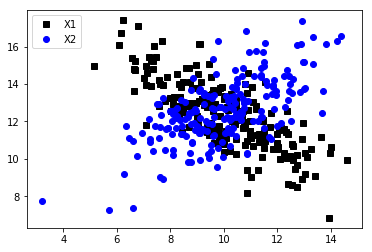

In [70]:
x0 = data.values[:-200, 0]
y0 = data.values[:-200, 1]
x1 = data.values[199:,0]
y1 = data.values[199:,1]
plt.plot(x0, y0, 'ks', label ='X1')
plt.plot(x1, y1, 'bo', label ='X2' )
plt.legend(loc='upper left')
plt.show()

Vemos claramente que la tarea de separar (clasificar) los puntos negros y azules es muy díficil siguiendo los principios de los clasificadores bayesianos ingenuos. La correlación de X1 y X2 expuesta en la gŕafica sugiere que la hipótesis de que las  probabilidades de los atributos sean independientes no es razonable en este ejemplo.

Formalmente, las distribuciones normales de $X1$ y la de $X2$ son tales que no podemos distinguir a los puntos a partir de las medias y las varianzas. La información que puede distinguir entre las dos clases de puntos es la covarianza. 